# boxsimu Tutorial

This tutorial assumes that you already have installed the package successfully via pip. If you haven't yet have a look into install.txt.

A note about the notation in the tutorial: Class names are always written with a leading upper case letter even if the word is used in plural.

### Overview

boxsimu is a simple modelling framework based on the principle of a system of discrete 0D-boxes interacting with each other. boxsimu offers a sipmple interface to define a system, its content and properties. Models defined in this way can than be simply solved and their evolution in time can be visualized.

A system is basically defined by instantiating the class BoxModelSystem and pass instances of the classes Box, Flow, and Flux.
The instance of the class BoxModelSystem then contains all information on the whole system while its components (Boxes, Flows, and Fluxes) store information on the distribution of Fluids and Variables in the system and how the different compartements exchange these quantities. The basic structure of a BoxModelSystem instance is shown below:

<img src='img/BoxModelSystemVisualization.png' width="60%">

A BoxModelSystem can contain an arbitrary number of Boxes, however, the more boxes there are the slower the system's simulation will be. Similarly the number of Fluxes, Flows, and Variables, Processes, Reactions within Boxes is only limited in regard of computational power. In contrast, every Box has only one Fluid.

Model definitions are contained within an instance of BoxModelSystem. This instance containes boxes filled with a well-mixed solution of a fluid and an arbitrary number of variables (tracers whose time evolution is analysed).
Boxes are connected with each other by flows of solution and fluxes of variables. The basic structure of a boxbimu 
model is visualized in the figure below:

The most important class that a user of BoxSimu is interacting with are:
- **BoxModelSystem**: Contains the whole system that a user wants to simulate and investigate.
- **Box**: Represents a compartement of the system.
- **Flow**: Represent a flow of Fluid between two boxes. This flow can passively transport Variables (e.g. a river that passively transport a lot of different chemical substances) but doesn't have to (e.g. evaporation from a lake into the atmosphere where almost pure water is transported).
- **Flux**: Represents a transport of a Variable that is not associated with the flow of a fluid (e.g. sedimentation of particles in a sea/ocean/atmosphere).
- **Variable**: Represents a tracer which time evolution is of interest to the user.
- **Process**: Represents sink or source mechanisms of a certain Variable.
- **Reaction**: Represents transformations between different Variables. Important is here that there is no mass conservation constraint. Thus a ''transformation'' of approximately 1kg of phosphate into 114kg of phytoplankton is a valid Reaction.

We will jump now right into a first simple example.

### Lake: A first simple 1-Box Model

Our first example consists of a box representing a freshwater lake that only has one inflow and one outflow. We want to try to simulate how the concentration of phosphate in this lake evolves over time. The inflow has a constant concentration of phosphate while the outflow has the same concentration as the lake itself. In order to make the volume (mass of water) of the lake constant over time the rate of inflow equals the rate of outflow. In the following we have a simple depicting of the lake system:

<img src='img/1D-lake-model2.png' width="50%">

This simple system can also be solved analytically. And we will do so in order to validate the output of boxsimu. So lets start with the defintion of all needed variables:

Variables:
- $V$ = Volume of the lake [m^3] (const. due to the fact that the water inflow equals the outflow)
- $m$ = Mass of phosphate in the lake [kg]
- $C$ = Concentration of phosphate in the lake [kg/m^3]
- $C_0$ = Concentration of phosphate in the lake at the begining of the simulation (t=0) [s]
- $C_{in}$ = Concentration of phosphate in the inflow [kg/m^3]
- $Q$ = Volumetric water flow rate of the Inflow and Outflow [m^3/s] 
- $t$ = Time [d]

- $k_w$ = $\frac{Q}{V}$ = Specific flow-rate [1/d]

Assumptions:
- $C_{in}$ = const. 

Based on the definition of our system given above we can set up the following differential equation:

$\frac{dm}{dt} = Q \cdot C_{in} - Q \cdot C$

We devide both sides by the volume of the lake ($V$) and use the specific flow rate $k_w$ on the right hand side (r.h.s.):

$\frac{1}{V}\frac{dm}{dt} = k_w \cdot C_{in} - k_w \cdot C = k_w (C_{in} - C)$

Now, since the volume of the box is constant, we can incorporate the volume into the time-derivative 
and end up with:

$\frac{dC}{dt} = k_w (C_{in} - C)$

The solution of this linear, inhomogene, ordinary differential equation is:

$C(t) = (C_0 - C_{in}) e^{-k_wt} + C_{in}$

The solution is plotted below for the following system:
- $V = 10^7m^3$
- $Q = 10^5\frac{m^3}{d}$
- $C_0 = 10^{-2}\frac{kg}{m^3}$
- $C_{in} = 3 \cdot 10^{-1}\frac{kg}{m^3}$

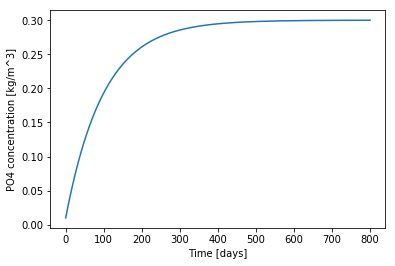

In [9]:
import matplotlib.pyplot as plt
import numpy as np

@np.vectorize
def C(t):
    V = 1e7
    Q = 1e5
    C0 = 1e-2
    Cin = 3e-1
    kw = Q/V
    return (C0-Cin)*np.exp(-kw*t) + Cin

t = np.linspace(0, 8e2, 1000)
c_phosphate = C(t)
plt.plot(t, c_phosphate)
plt.xlabel('Time [days]')
plt.ylabel('PO4 concentration [kg/m^3]')

We can see that the system reaches a steady-state after about $400$ days.

Now we want to use boxsimu to simulate the system...

In [8]:
import sys
import os
import numpy as np

# import boxsimu


BOXSIMU_PATH = '/home/aschi/Documents/MyPrivateRepo/boxsimu_project/'
if not BOXSIMU_PATH in sys.path:
    sys.path.append(BOXSIMU_PATH)

import boxsimu
from boxsimu import ur

#############################
# FLUIDS
#############################
freshwater = boxsimu.Fluid('freshwater', rho=1000*ur.kg/ur.meter**3)

#############################
# VARIABLES
#############################
po4 = boxsimu.Variable('po4')

#############################
# PROCESSES
#############################
# No processes in this system

#############################
# REACTIONS
#############################
# No reactions in this system

#############################
# BOXES
#############################

volume_lake = 1e7*ur.meter**3
mass_lake_water = volume_lake * freshwater.rho
mass_lake_po4_initial = 1e-2*ur.kg/ur.meter**3 * volume_lake
lake = boxsimu.Box(
    name='lake',
    name_long='Little Lake',
    fluid=freshwater.q(mass_lake_water),
    variables=[po4.q(mass_lake_po4_initial)],
)

#############################
# FLOWS
#############################
inflow = boxsimu.Flow(
    name='Inflow', 
    source_box=None,
    target_box=lake,
    rate=1e7*ur.kg/ur.day,
    tracer_transport=True,
)
outflow = boxsimu.Flow(
    name='Outflow',
    source_box=lake,
    target_box=None,
    rate=1e7*ur.kg/ur.day,
    tracer_transport=True,
)

#############################
# FLUXES
#############################
# No fluxes in this system

#############################
# BoxModelSystem
#############################
system = boxsimu.BoxModelSystem('Simple Lake Box Model',
    boxes=[lake,], 
    flows=[inflow, outflow,],
)

In [9]:
sol = system.solve(500*ur.year, 25*ur.year)

Start solving the box model...
- total integration time: 500 year
- dt (time step): 25 year
0
1
10.0%
2
3
20.0%
4
5
30.0%
6
7
40.0%
8
9
50.0%
10
11
60.0%
12
13
70.0%
14
15
80.0%
16
17
90.0%
18
19
Function "solve(...)" used 0.251s


(<matplotlib.figure.Figure at 0x7fd9b9198128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9bb969550>)

/home/aschi/Envs/boxsimu/lib/python3.6/site-packages/matplotlib/ticker.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


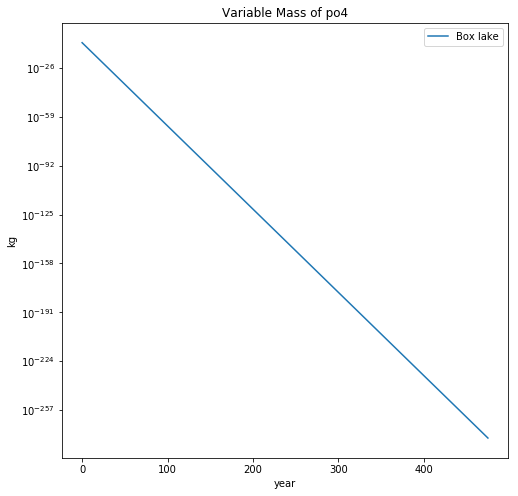

In [10]:
sol.plot_variable_mass_of_all_boxes(system.variables.po4)

(<matplotlib.figure.Figure at 0x7fd9b99114a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9bc75ca90>)

/home/aschi/Envs/boxsimu/lib/python3.6/site-packages/matplotlib/ticker.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


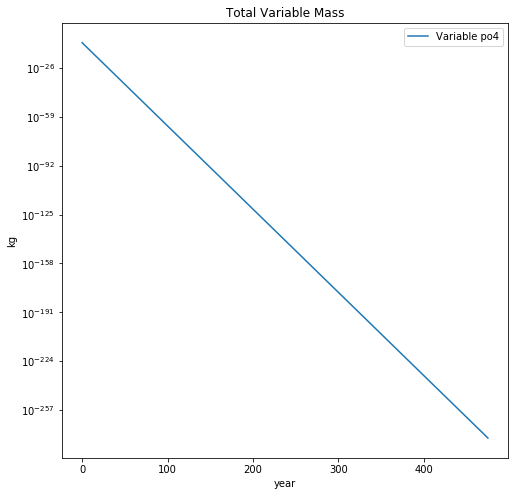

In [6]:
sol.plot_total_variable_masses()

box_mass:  10000100000.0 kilogram
1.66414692378e-286


(<matplotlib.figure.Figure at 0x7fd9b95c0518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9b96072b0>)

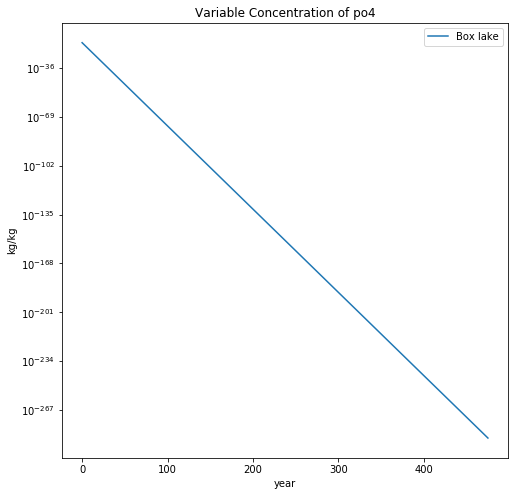

In [7]:
sol.plot_variable_concentration_of_all_boxes(system.variables.po4)